This notebook implements condition classification based on a convolutional network.

In [2]:
import sys
sys.path
sys.path.append('/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/code')
sys.path.append('/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import matplotlib.animation as animation
import tembedding
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS
import math
from joblib import Memory,Parallel,delayed,parallel_backend
import time
from multiprocessing import Lock, Process, Queue
import multiprocessing
import queue 
import os
import networkx as nx
from scipy.spatial.transform import Rotation as R

In [45]:
import importlib
importlib.reload(package.torch_classifier)
importlib.reload(cebra2.distribution)
importlib.reload(cebra2.dataset)

<module 'cebra_v2.dataset' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/dataset.py'>

## Data Loading

In [4]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/dfc.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/meta.csv")
n_wins = 461
id_sessions_awake_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake" and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']]
id_sessions_light_propofol_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "light-propofol" and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']]
id_sessions_deep_propofol_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "deep-propofol" and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']]
id_sessions_light_sevoflurane_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2" and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']]
id_sessions_deep_sevoflurane_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4" and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']]
id_sessions_awake_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake" and meta["monkey"].iloc[i] in ['jade']]
id_sessions_light_propofol_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "light-propofol" and meta["monkey"].iloc[i] in ['jade']]
id_sessions_deep_propofol_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "deep-propofol" and meta["monkey"].iloc[i] in ['jade']]
id_sessions_light_sevoflurane_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2" and meta["monkey"].iloc[i] in ['jade']]
id_sessions_deep_sevoflurane_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4" and meta["monkey"].iloc[i] in ['jade']]

In [14]:
#if original data
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")
n_runs = len(meta)
n_wins = 464
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake', 'light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_test = dfc[(meta["monkey"] == "jade") & meta["condition"].isin(['awake', 'light-propofol', 'deep-propofol'])].reshape((-1, n_wins, 82, 82))
dfc_all = dfc.reshape((-1, n_wins, 82, 82))

KeyboardInterrupt: 

In [5]:
def STRUCTURE(x,y):
        return 1 - package.preprocessing.structure(x,y,is_batch = False)

metric = STRUCTURE

In [5]:
id_awake_sevoflurane_train = np.concatenate([id_sessions_awake_train,id_sessions_light_sevoflurane_train,id_sessions_deep_sevoflurane_train])
X = dfc[id_awake_sevoflurane_train,:,:].reshape(-1,1,82,82)
y = np.array([0]*461*len(id_sessions_awake_train) + [1]*461*len(id_sessions_light_sevoflurane_train) + [1]*461*len(id_sessions_deep_sevoflurane_train))
id_awake_sevoflurane_test = np.concatenate([id_sessions_awake_test,id_sessions_light_sevoflurane_test,id_sessions_deep_sevoflurane_test])
X_val = dfc[id_awake_sevoflurane_test,:,:].reshape(-1,1,82,82)
y_val = np.array([0]*461*len(id_sessions_awake_test) + [1]*461*len(id_sessions_light_sevoflurane_test) + [1]*461*len(id_sessions_deep_sevoflurane_test))

In [68]:
structural = np.loadtxt("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/structural.txt")

## Conv Network

In [19]:
import importlib
importlib.reload(package.torch_classifier)

<module 'package.torch_classifier' from '/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/code/package/torch_classifier.py'>

In [44]:
net = package.torch_classifier.CNN1(n_classes = 2)
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)
train = package.torch_classifier.SimpleDataset(X_train,y_train)
test = package.torch_classifier.SimpleDataset(X_test,y_test)
balanced_batch_sampler = package.torch_classifier.BalancedBatchSampler(train, n_classes = 2, n_samples = 100)
train_loader = torch.utils.data.DataLoader(train, batch_sampler = balanced_batch_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=True, num_workers=6)

In [45]:
package.torch_classifier.Train(net,train_loader,test_loader,10,lr = 0.01)

Train loss 0.3154, Train accuracy 88.11%
Test accuracy 94.02%
Train loss 0.0012, Train accuracy 100.00%
Test accuracy 94.13%
Train loss 0.0005, Train accuracy 100.00%
Test accuracy 94.13%
Train loss 0.0003, Train accuracy 100.00%
Test accuracy 94.13%
End of training.



## Grad CAM

In [527]:
print(net)

CNN1(
  (fc1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (fc2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (fc3): MaxPool2d(kernel_size=(5, 5), stride=(5, 5), padding=0, dilation=1, ceil_mode=False)
  (fc4): Flatten(start_dim=1, end_dim=-1)
  (fc5): Linear(in_features=1125, out_features=50, bias=True)
  (fc6): Linear(in_features=50, out_features=2, bias=True)
  (fc7): LogSoftmax(dim=1)
)


In [46]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook_function(module, grad_input, grad_output, verbose = False):
  global gradients # refers to the variable in the global scope
  if verbose : 
    print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  if verbose : 
    print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook_function(module, args, output, verbose = False):
  global activations # refers to the variable in the global scope
  if verbose : 
    print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  if verbose : 
    print(f'Activations size: {activations.size()}')

In [47]:
from collections import OrderedDict
net.fc2._forward_hooks = OrderedDict({})
net.fc2._backward_hooks = OrderedDict({})

In [48]:
backward_hook = net.fc2.register_full_backward_hook(backward_hook_function, prepend=False)
forward_hook = net.fc2.register_forward_hook(forward_hook_function, prepend=False)

In [137]:
len(id_sessions_awake_train)

13

In [54]:
img = X[10*461+300,:,:]
img_tensor = torch.Tensor(img).unsqueeze(0).type(torch.float32)
label = y[10*461]

In [55]:
pred = net(img_tensor)
pred.backward(torch.ones((1,2)))

In [56]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

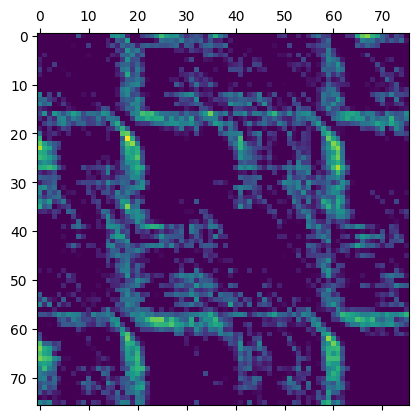

tensor([[1.0000e+00, 2.9672e-07]], grad_fn=<ExpBackward0>)
0


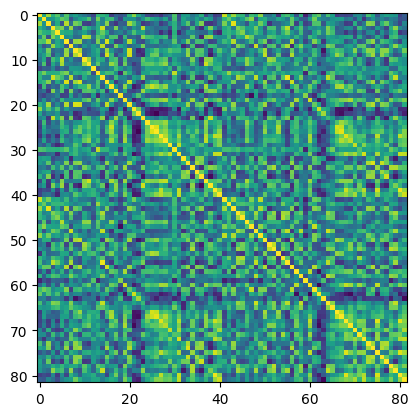

In [57]:
# weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.detach())
plt.show()

print(torch.exp(pred))
print(label)
plt.imshow(img[0,:,:])

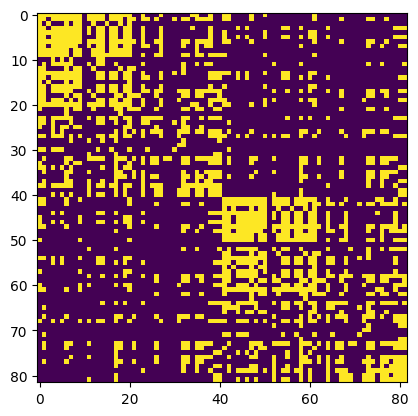

In [70]:
plt.imshow(structural > 2)

In [296]:
filter_maps = net.fc1.weight.detach().numpy()

### Mean feature maps

In [148]:
len(id_sessions_light_sevoflurane_train)

18

In [182]:
sum_heatmap = torch.zeros((76,76))
for session in range(13+18+18):
    for i in range(461):
        if y[session*461+i] == 2:
            img_tensor = torch.Tensor(X[session*461+i,:,:]).unsqueeze(0).type(torch.float32)
            pred = net(img_tensor)
            pred.backward(torch.ones((1,3)))
            pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
            # weight the channels by corresponding gradients
            for i in range(activations.size()[1]):
                activations[:, i, :, :] *= pooled_gradients[i]

            # average the channels of the activations
            heatmap = torch.mean(activations, dim=1).squeeze()

            # relu on top of the heatmap
            heatmap = F.relu(heatmap)

            # normalize the heatmap
            heatmap /= torch.max(heatmap)

            sum_heatmap += heatmap
        

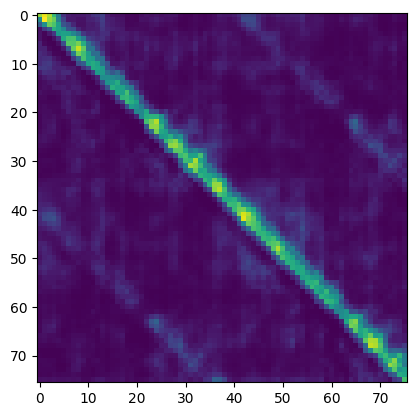

In [158]:
plt.imshow(sum_heatmap.detach().numpy())

## Test sur Jade

In [159]:
forward_hook.remove()
backward_hook.remove()

In [20]:
valid = package.torch_classifier.SimpleDataset(X_val,y_val)
valid_loader = torch.utils.data.DataLoader(valid, batch_size = 1000)

In [24]:
pred[:,0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [26]:
net.eval()

# loop, over whole test set
compteur_batch = 0
net.eval()
test_correct = np.array([0,0])
nb_test = np.array([np.sum(y_val == 0),np.sum(y_val == 1)])

for i, (batch,target) in enumerate(valid_loader):
    output = net(batch)
    pred = output.max(1, keepdim=True)[1][:,0].detach()
    test_correct[0] += ((pred == 0) * (target.detach() == 0)).sum()
    test_correct[1] += ((pred == 1) * (target.detach() == 1)).sum()
    
print(100 * test_correct / nb_test)

[90.45553145 88.41028819]


In [33]:
pred

tensor([[-5.8412e-06, -1.2043e+01]], grad_fn=<LogSoftmaxBackward0>)

In [34]:
sum_heatmap = torch.zeros((2,76,76))
for session in range(X_val.shape[0]//461):
    print(session)
    for i in range(461):

        img_tensor = torch.Tensor(X_val[session*461+i,:,:]).unsqueeze(0).type(torch.float32)
        probas = net(img_tensor)
        probas.backward(torch.ones((1,2)))
        pred = torch.argmax(probas)
        pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
        # weight the channels by corresponding gradients
        for i in range(activations.size()[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        # average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()

        # relu on top of the heatmap
        heatmap = F.relu(heatmap)
        # normalize the heatmap
        #heatmap /= torch.max(heatmap)

        sum_heatmap[pred,:,:] += heatmap


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


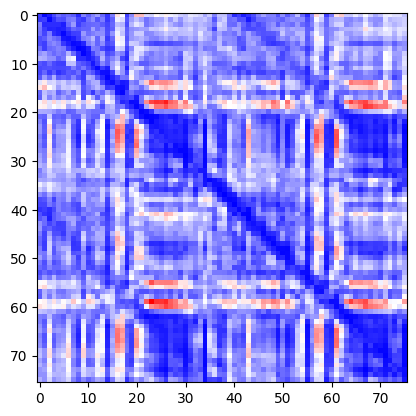

In [41]:
plt.imshow(sum_heatmap[0,:].detach().numpy(),cmap = "bwr")

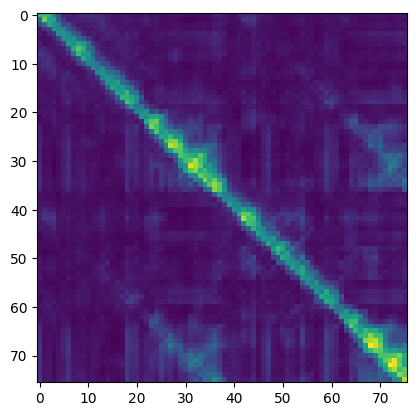

In [171]:
plt.imshow(sum_heatmap.detach().numpy())

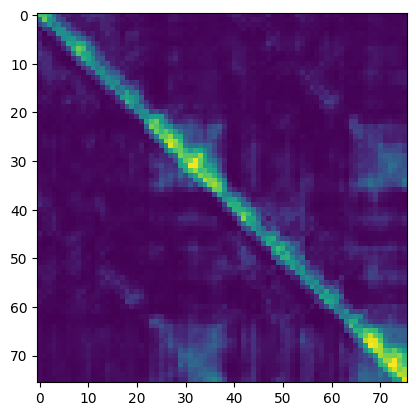

In [167]:
plt.imshow(sum_heatmap.detach().numpy())

## Conv with light vs deep